In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sbibm

/Users/jonas.arruda/PyCharm Projects/diffusion-experiments/.venv_sbi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_model_config():
    colors = {
        # Flow Matching family
        "flow_matching": "#1B9E77",
        "ot_flow_matching": "#33A02C",
        "flow_matching_edm": "#66C2A5",

        # EDM family
        "diffusion_edm_vp": "#E7298A",
        "diffusion_edm_vp_ema": "#AD1457",
        "diffusion_edm_ve": "#FB9A99",

        # Cosine family
        "diffusion_cosine_F": "#7570B3",
        "diffusion_cosine_v": "#9E9AC8",
        "diffusion_cosine_noise": "#54278F",

        # Consistency family
        "consistency_model": "#D95F02",
        "stable_consistency_model": "#E6AB02",
    }
    return {"visualization": {"colors": colors}}

def model_name(k):
    names = {
        "flow_matching":r"Flow Matching$\,$",
        "ot_flow_matching":r"Flow Matching (OT)$\,$",
        "flow_matching_edm":r"Flow Matching ($\rho = -0.6$)$\,$",
        "consistency_model":r"Discrete Consistency Model$\,$",
        "stable_consistency_model":r"Continuous Consistency Model$\,$",
        "diffusion_edm_vp":r"VP EDM$\,$",
        "diffusion_edm_ve":r"VE EDM$\,$",
        "diffusion_edm_vp_ema":r"VP EDM EMA$\,$",
        "diffusion_cosine_F":r"Cosine $\boldsymbol{F}$-pred.$\,$",
        "diffusion_cosine_v":r"Cosine $\boldsymbol{v}$-pred.$\,$",
        "diffusion_cosine_noise":r"Cosine $\boldsymbol{\epsilon}$-pred.$\,$",
        "MCMC":"MCMC",
    }
    return names.get(k, k.replace("_"," ").title())

# from model_settings_benchmark import create_adapter, ADAPTER_SETTINGS
# for i in range(10):
#     task = sbibm.get_task(sbibm.get_available_tasks()[i])
#     print(f"{i}: {task.name_display}, dim_parameters={task.dim_parameters}, dim_data={task.dim_data}")
#     # plot prior
#     prior_samples = task.get_prior()(1000).numpy()
#     adapter = create_adapter(ADAPTER_SETTINGS[task.name])
#     prior_samples = adapter.forward(dict(inference_variables=prior_samples))['inference_variables']
#     fig, ax = plt.subplots(1, task.dim_parameters, figsize=(12, 2), layout='constrained', sharex=True)
#     for p in range(task.dim_parameters):
#         ax[p].hist(prior_samples[:, p], bins=30, density=True)
#     plt.show()

In [3]:
# Load the dataset
results = pd.read_csv('c2st_benchmark_results.csv')
results.head()

,Model-Sampler,gaussian_linear,gaussian_linear_std,sir,sir_std,gaussian_linear_uniform,gaussian_linear_uniform_std,bernoulli_glm,bernoulli_glm_std,gaussian_mixture,...,lotka_volterra,lotka_volterra_std,slcp,slcp_std,slcp_distractors,slcp_distractors_std,bernoulli_glm_raw,bernoulli_glm_raw_std,sampler,model
0,flow_matching-ode,0.86953,0.064317,1.00000,0.000000,0.852465,0.055136,0.660180,0.044992,0.657400,...,0.999900,0.000092,0.954270,0.025740,0.994200,0.005073,0.947585,0.021330,ode,flow_matching
1,flow_matching_edm-ode,0.84655,0.090629,1.00000,0.000000,0.822255,0.044485,0.677195,0.035547,0.657055,...,0.999920,0.000087,0.900935,0.032346,0.989415,0.009191,0.938710,0.042417,ode,flow_matching_edm
2,ot_flow_matching-ode,0.81179,0.059853,1.00000,0.000000,0.837170,0.035256,0.887725,0.046759,0.886095,...,0.999775,0.000221,0.921410,0.030513,0.987685,0.005011,0.882225,0.056796,ode,ot_flow_matching
3,consistency_model-ode,0.79140,0.044248,0.99998,0.000046,0.737540,0.050407,0.646720,0.051948,0.637075,...,0.999875,0.000072,0.862535,0.044299,0.988675,0.010152,0.885235,0.036367,ode,consistency_model
4,stable_consistency_model-ode,0.60379,0.020835,1.00000,0.000000,0.684655,0.045264,0.659675,0.041759,0.561100,...,0.999885,0.000095,0.886480,0.049767,0.987675,0.006045,0.780290,0.066089,ode,stable_consistency_model


In [4]:
ONLY_SHOW_ODE = True
FILTER_BEST_SAMPLER = True

In [5]:
# Melt the dataframe into long form
value_vars = [col for col in results.columns if not col.endswith('_std') and col not in ['Model-Sampler', 'sampler', 'model']]
std_vars = [col for col in results.columns if col.endswith('_std')]
long_df = results.melt(id_vars=['Model-Sampler'], value_vars=value_vars, var_name='problem', value_name='cs2t')

# Merge corresponding std values
std_long = results.melt(id_vars=['Model-Sampler'], value_vars=std_vars, var_name='problem_std', value_name='std')
std_long['problem'] = std_long['problem_std'].str.replace('_std', '', regex=False)
long_df['std'] = std_long['std']

# Rank models within each problem (lower error = better rank)
long_df['error'] = np.abs(long_df['cs2t'] - 0.5)
long_df['rank'] = long_df.groupby('problem')['error'].rank(method='min', ascending=True)

# Extract model and sampler identifiers
long_df['model'] = long_df['Model-Sampler'].apply(lambda x: x.split('-')[0])
long_df['sampler'] = long_df['Model-Sampler'].apply(lambda x: x.split('-')[1])

if FILTER_BEST_SAMPLER:
    # Find the best sampler (lowest mean rank) per model
    mean_ranks = long_df.groupby(['model', 'sampler'])['rank'].mean().reset_index()
    best_samplers = mean_ranks.loc[mean_ranks.groupby('model')['rank'].idxmin(), ['model', 'sampler']]
    long_df = long_df.merge(best_samplers, on=['model', 'sampler'])
    ONLY_SHOW_ODE = False

# Retrieve colors
config = create_model_config()
colors = config["visualization"]["colors"]

problem_names = np.array([sbibm.get_task(long_df.problem.unique()[i]).name_display for i in range(10)])
problem_dim = [sbibm.get_task(long_df.problem.unique()[i]).dim_parameters for i in range(10)]
data_dim = [sbibm.get_task(long_df.problem.unique()[i]).dim_data for i in range(10)]
problem_names = np.array([f'{n}\ndim$=({p_dim}, {d_dim})$' for n, p_dim, d_dim in zip(problem_names, problem_dim, data_dim)])
problem_order = np.lexsort((data_dim, problem_dim))

/Users/jonas.arruda/PyCharm Projects/diffusion-experiments/.venv_sbi/lib/python3.11/site-packages/diffeqtorch/diffeqtorch.py:29: UserWarning: JULIA_SYSIMAGE_DIFFEQTORCH not set
  warn("JULIA_SYSIMAGE_DIFFEQTORCH not set")


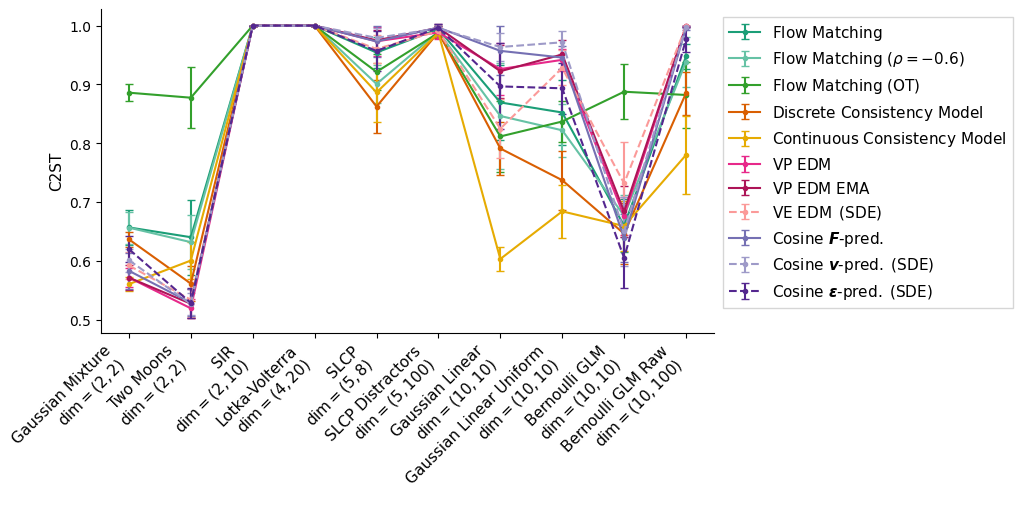

In [6]:
# Plot
fig = plt.figure(figsize=(10, 5), layout='constrained')
for model in long_df['Model-Sampler'].unique():
    subset = long_df[long_df['Model-Sampler'] == model]
    base_name = subset['model'].values[0]
    sampler = subset['sampler'].values[0]
    if sampler == 'sde'  and ONLY_SHOW_ODE:
        continue
    color = colors.get(base_name, 'gray')
    plt.errorbar(subset['problem'].values[problem_order],
                 subset['cs2t'].values[problem_order],
                 yerr=subset['std'].values[problem_order],
                 label=model_name(base_name) if sampler == 'ode' else model_name(base_name) + ' (SDE)',
                 linestyle='-' if sampler == 'ode' else '--',
                 markersize=3, capsize=3, color=color, marker='o')

plt.xticks(rotation=45, ha='right', labels=problem_names[problem_order], ticks=np.arange(len(problem_names)), fontsize=11)
plt.ylabel('C2ST', fontsize=11)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1), ncol=1, fancybox=False, fontsize=11)
ax = fig.get_axes()
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
fig.savefig(f'c2st_benchmark{"_best" if FILTER_BEST_SAMPLER else "_all"}.pdf', bbox_inches='tight')
plt.show()

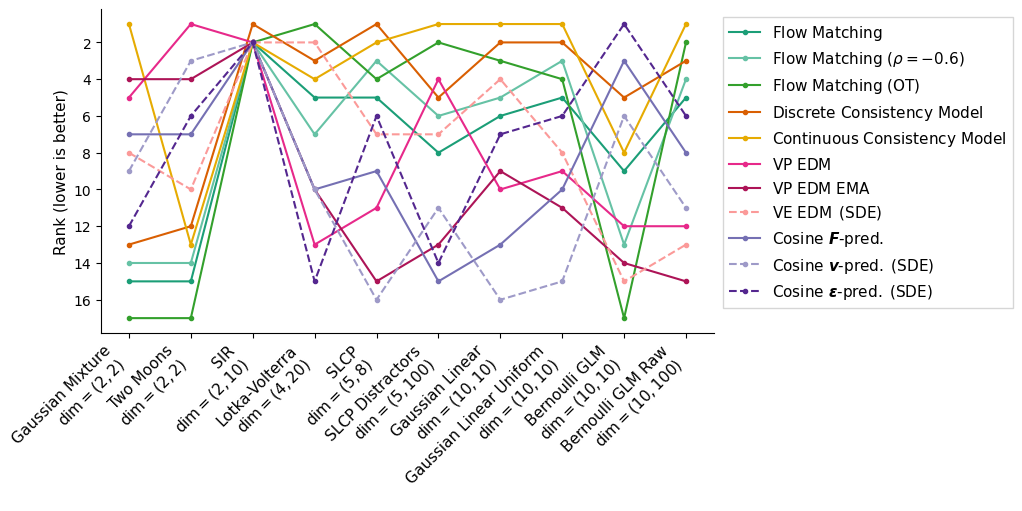

In [7]:
# Plot
fig = plt.figure(figsize=(10, 5), layout='constrained')
for model in long_df['Model-Sampler'].unique():
    subset = long_df[long_df['Model-Sampler'] == model]
    base_name = subset['model'].values[0]
    sampler = subset['sampler'].values[0]
    if sampler == 'sde' and ONLY_SHOW_ODE:
        continue
    color = colors.get(base_name, 'gray')
    plt.plot(subset['problem'].values[problem_order], subset['rank'].values[problem_order],
             label=model_name(base_name) if sampler == 'ode' else model_name(base_name) + ' (SDE)',
             linestyle='-' if sampler == 'ode' else '--',
             color=color, markersize=3,
             marker='o')

plt.xticks(rotation=45, ha='right', labels=problem_names[problem_order], ticks=np.arange(len(problem_names)), fontsize=11)
plt.ylabel('Rank (lower is better)', fontsize=11)
plt.gca().invert_yaxis()
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1), ncol=1, fancybox=False, fontsize=11)
ax = fig.get_axes()
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
fig.savefig(f'c2st_benchmark_ranks{"_best" if FILTER_BEST_SAMPLER else "_all"}.pdf', bbox_inches='tight')
plt.show()